In [106]:
# Packages

using DelimitedFiles
using StatsBase
using Interpolations
using Plots
using LaTeXStrings
using FFTW
using Distributions
using Profile
using PyCall
using SpecialFunctions
using Optim
using StaticArrays
using Healpix
using BenchmarkTools

# Importing the necessary python libraries
@pyimport matplotlib.pyplot as plt
@pyimport numpy as np
@pyimport healpy as hp

In [107]:
# Getting the model-dependent neutrino distribution

model_2 = readdlm("nu_models/second_GC_model.txt", comments=true)
numv = size(model_2)[1]


# Histogramming and interpolating the distribution

bsize = 0.3
xbins, ybins, zbins = -30:bsize:30, -30:bsize:30, -3:bsize:3
nubins= fit(Histogram, (vec(model_2[:, 24]), vec(model_2[:, 25]), vec(model_2[:, 26])), (xbins, ybins, zbins), closed=:left)

binvals = nubins.weights ./ (numv*bsize^3)
xedges = view(collect(xbins), 1:length(xbins)-1)
yedges = view(collect(ybins), 1:length(ybins)-1)
zedges = view(collect(zbins), 1:length(zbins)-1)
# pop!(xedges)
# pop!(yedges)
# pop!(zedges)

# Interpolating the distribution to get a continuous function, and assuming zero neutrinos outside the sampled window
pds = Interpolations.interpolate((xedges, yedges, zedges), binvals, Gridded(Linear()))
probdens = extrapolate(pds, 0.0)

# To not have the massive array show up, throwaway variable
zcx=0

0

In [108]:
eff_a = readdlm("EffA_GC_approx_2.csv", ',')
itp = Interpolations.interpolate((eff_a[:, 1] ./ 1000,), eff_a[:, 2], Gridded(Linear())) # in m^2
effarea = extrapolate(itp, 0.0)

# The min and max energy vals (in TeV) we consider based on the limits of the effective area function
emin = 0.7249213596719925
emax = 1099.9079675727165

1099.9079675727164

In [109]:
# Functions that return areas of square latitude-longitude bins on a sphere's surface

function spherebinareas(r)
    ϕs = range(0, 2π, length=50)
    θs = range(-π/2, π/2, length=25)

    Δϕ = ϕs[2] - ϕs[1]
    sinθs = sin.(θs)

    bin = zeros(length(ϕs)-1, length(θs)-1)

    for i in 1:length(ϕs)-1
        for j in 1:length(θs)-1
            bin[i, j] = r^2 * Δϕ * (sin(θs[j+1]) - sin(θs[j]))
        end
    end

    return bin
end

# Function that returns the area on a sphere of radius r for an angular bin centered at angle (l, b) with size θ
function sbinarea(r, l, b, θ)

    Δl = θ

    Δsinb = abs(sin(b+(θ/2)) - sin(b-(θ/2)))

    area = r^2 * Δl * Δsinb

end

function sbinareas1(r, bsize)


    bedges = (-π/2):bsize:(π/2)
    ledges = 0:bsize:(2π)

    bbins = collect((-π/2 + bsize/2):bsize:(π/2 - bsize/2))
    lbins = collect((0 + bsize/2):bsize:(2π - bsize/2))

    bin = zeros(length(lbins), length(bbins))

    for (i, l) in enumerate(lbins)
        for (j, b) in enumerate(bbins)
            bin[i, j] = sbinarea(r, l, b, bsize)
        end
    end

    return bin
end


# Flux calculation functions 

function osce(et, dm2, leff)

    # Norms squared of the PMNS matrix (exact vals might change but always needs to be unitary)
    u = @SMatrix [0.674743 0.302844 0.0224125;
                  0.0946105 0.360415 0.544974;
                  0.230646 0.33674 0.432613]

    # Conversion factor to go from kpc to 1/eV
    convfactor = 3.086e19 * 5.06773093741 * 1e6

    leff *= convfactor

    # Assuming uniform mass splitting over all three mass states
    osc = (cos((dm2 * leff)/(4*et*1e12)))^2

    prob_ee = osc*((u[1]*u[1]) + (u[4]*u[4]) + (u[7]*u[7]))
    prob_μe = osc*((u[1]*u[2]) + (u[4]*u[5]) + (u[7]*u[8]))

    prob_e = 0.666666*(prob_μe) + 0.333333*(prob_ee)
end

function oscτ(et, dm2, leff)

    # Norms squared of the PMNS matrix (exact vals might change but always needs to be unitary)
    u = @SMatrix [0.674743 0.302844 0.0224125;
                  0.0946105 0.360415 0.544974;
                  0.230646 0.33674 0.432613]

    # Conversion factor to go from kpc to 1/eV
    convfactor = 3.086e19 * 5.06773093741 * 1e6

    leff *= convfactor

    # Assuming uniform mass splitting over all three mass states
    osc = (cos((dm2 * leff)/(4*et*1e12)))^2

    prob_eτ = osc*((u[3]*u[1]) + (u[6]*u[4]) + (u[9]*u[7]))
    prob_μτ = osc*((u[3]*u[2]) + (u[6]*u[5]) + (u[9]*u[8]))

    prob_τ = 0.666666*(prob_μτ) + 0.333333*(prob_eτ)
end

function oscμ(et, dm2, leff)

    # Norms squared of the PMNS matrix (exact vals might change but always needs to be unitary)
    u = @SMatrix [0.674743 0.302844 0.0224125;
                  0.0946105 0.360415 0.544974;
                  0.230646 0.33674 0.432613]

    # Conversion factor to go from kpc to 1/eV
    convfactor = 3.086e19 * 5.06773093741 * 1e6

    leff *= convfactor

    # Assuming uniform mass splitting over all three mass states
    osc = (cos((dm2 * leff)/(4*et*1e12)))^2

    prob_eμ = osc*((u[2]*u[1]) + (u[5]*u[4]) + (u[8]*u[7]))
    prob_μμ = osc*((u[2]*u[2]) + (u[5]*u[5]) + (u[8]*u[8]))

    prob_μ = 0.666666*(prob_μμ) + 0.333333*(prob_eμ)
end

function oscprob(et, dm2, leff)

    # Norms squared of the PMNS matrix (exact vals might change but always needs to be unitary)
    u = @SMatrix [0.674743 0.302844 0.0224125;
                  0.0946105 0.360415 0.544974;
                  0.230646 0.33674 0.432613]

    # Conversion factor to go from kpc to 1/eV
    convfactor = 3.086e19 * 5.06773093741 * 1e6

    leff *= convfactor

    # Assuming uniform mass splitting over all three mass states
    osc = (cos((dm2 * leff)/(4*et*1e12)))^2

    prob_ee = osc*((u[1]*u[1]) + (u[4]*u[4]) + (u[7]*u[7]))
    prob_μe = osc*((u[1]*u[2]) + (u[4]*u[5]) + (u[7]*u[8]))

    prob_eτ = osc*((u[3]*u[1]) + (u[6]*u[4]) + (u[9]*u[7]))
    prob_μτ = osc*((u[3]*u[2]) + (u[6]*u[5]) + (u[9]*u[8]))

    prob_eμ = osc*((u[2]*u[1]) + (u[5]*u[4]) + (u[8]*u[7]))
    prob_μμ = osc*((u[2]*u[2]) + (u[5]*u[5]) + (u[8]*u[8]))

    prob_e = 0.333333prob_ee + 0.666666prob_μe
    prob_τ = 0.333333prob_eτ + 0.666666prob_μτ
    prob_μ = 0.333333prob_eμ + 0.666666prob_μμ

    # νμ contribution comes from the 25% chance of a neutral current interaction, which appears as a cascade
    prob_cascade = prob_e + prob_τ + 0.25prob_μ
end

function flux(et, x, y, z, γ)
    ϕ₀ = 21.8e-16 * 3.156e8 # TeV^-1 cm^-2 10 yr^-1
    e0 = 100.0 # TeV
    as = ϕ₀ * (et/e0)^(-γ)
    flx = probdens(x, y, z) * as
end

function flx(et)
    ϕ₀ = 21.8
    γ = 2.7
    e0 = 100
    flx = ϕ₀ * (et/e0)^(-γ) * 1e-16 * 3.156e8
end

function flxpdf(et, x, y, z)
    pds = probdens.(x, y, z)
    e0 = 100.0 # TeV
    # The 1.35911 normalization factor gives us the correct number of events (up to errors in digitizing of the effective area)
    # that accounts for the taus and neutral currents incorporated into the oscillation probability function
    as = 21.8 * (et/e0)^(-2.7) * 3.156e-8 * 1.35911
    pds * as
end

function cartesian(r, l, b)
    x = 8 - r*cos(l)*cos(b)
    y = r*sin(l)*cos(b)
    z = r*sin(b)
    return [x, y, z]
end

function cartx(r, l, b)
    x = 8 - r*cos(l)*cos(b)
    return x
end

function carty(r, l, b)
    y = r*sin(l)*cos(b)
    return y
end

function cartz(r, l, b)
    z = r*sin(b)
    return z
end

cartz (generic function with 1 method)

In [110]:
function fluxfreeparams(et, x, y, z, ϕ₀, γ)
    pds = probdens.(x, y, z)
    e0 = 100.0 # TeV
    # The 1.35911 normalization factor gives us the correct number of events (up to errors in digitizing of the effective area)
    # that accounts for the taus and neutral currents incorporated into the oscillation probability function
    as = ϕ₀ * (et/e0)^(-γ) * 3.156e-8 * 1.35911
    pds * as
end

# Specialized for efficiency inside the event distribution calculation function
function fluxfreeparams1(et, x, y, z, ϕ₀, γ)
    pds = probdens.(x, y, z)
    e0 = 100.0 # TeV
    et = @. ϕ₀ * (et/e0)^(-γ) * 3.156e-8 * 1.35911
    mat = pds .* transpose(et)
end

function smearedeventdistfreeparams(dm2, l, b, σ, ϕ₀, γ, θ, nsteps)

    # Mutates emptymat and ur
    function fstrippedmat!(emptymat, ur, dm2, l, b, θ, ϕ₀, γ)
        ur .= 10 .^ ur
        r0, rmax = 0, 30
        blength = 0.5
        rbins = range(r0, stop=rmax, step=blength)
        for i in 1:length(ur)
            for j in 1:length(rbins)
                vols = blength * oscprob(ur[i], dm2, rbins[j]) * sbinarea(rbins[j], l, b, θ)
                emptymat[j, i] = vols
            end 
        end
        flx = fluxfreeparams1(ur, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), ϕ₀, γ)
        vec(sum(flx .* emptymat, dims=1)) .* (effarea.(ur) * 10000)
    end

    # The -1 and 0.5 are sorta arbitrary constants that shift the function enough to provide correct results (hehe)
    samples = range(-1, log10(emax)+1, length=300)
    de = samples[2]-samples[1]

    # Altered PDF from the Galactic plane paper
    pdf_func(ur) = @. log(10) * exp10(ur - 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
    gsample = pdf_func(samples)
    g_fft = fft(gsample)

    emptymat = zeros(61, length(samples)) # 61 from the sampling frequency along r
    fsample = fstrippedmat!(emptymat, collect(samples), dm2, l, b, θ, ϕ₀, γ)
    f_fft = fft(fsample)
    C = f_fft .* g_fft
    c = real(ifft(C)) .* de

    # Again shifting the function to fit with expectation
    cut = trunc(Int, (1)/de)
    c1 = vcat(c[(cut+1):end], zeros(cut))

    fg = Interpolations.interpolate((samples,), c1, Gridded(Linear()))

    loges = range(log10(emin), log10(emax), nsteps)
    output = fg.(loges)
end

function edistbinnedfreeparams(dm2, l, b, σ, θ, ϕ₀, γ)
    nbins = 50 # An admittedly arbitrary number of bins, should probably find a more intelligent number
    nsteps = 1000
    us = range(log10(emin), log10(emax), nsteps)    
    du = us[2] - us[1]
    steps = smearedeventdistfreeparams(dm2, l, b, σ, ϕ₀, γ, θ, nsteps) .* du .* (10 .^ us) .* log(10)
    matrix = reshape(steps, (20, :)) # This 2 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    νbins = vec(sums)
end


# Likelihood functions

function poissonlog(data, hyp)
    # Avoiding weird /0 scenarios
    if hyp < 1e-20
        hyp = 1e-20
    end
    val = log((hyp^data) * exp(-hyp) / gamma(data+1))
end

function negloglh(dm2, l, b, θ, ϕ₀, γ)

    nullhyp = edistbinnedfreeparams(0, l, b, 0.5, θ, 21.8, 2.7)
    althyp = edistbinnedfreeparams(dm2, l, b, 0.5, θ, ϕ₀, γ)

    altsummand = poissonlog.(nullhyp, althyp)

    nloglh = -sum(altsummand)
end

function maxlh(dm2, l, b, θ)

    function nllh(test)
        return negloglh(dm2, l, b, θ, test[1], test[2])
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, NelderMead())
end

function lrt(null, alt)
    altsummand = sum(poissonlog.(null, alt) .- poissonlog.(null, null))
    ts = -2 * altsummand
end

lrt (generic function with 1 method)

In [111]:
function smearedeventdistfreeparams_test(dm2, l, b, σ, ϕ₀, γ, θ, nsteps, samplefreq)

    # Mutates emptymat and ur
    function fstrippedmat!(emptymat, ur, dm2, l, b, θ, ϕ₀, γ)
        ur .= 10 .^ ur
        r0, rmax = 0, 30
        blength = 0.5
        rbins = range(r0, stop=rmax, step=blength)
        for i in 1:length(ur)
            for j in 1:length(rbins)
                vols = blength * oscprob(ur[i], dm2, rbins[j]) * sbinarea(rbins[j], l, b, θ)
                emptymat[j, i] = vols
            end 
        end
        flx = fluxfreeparams1(ur, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), ϕ₀, γ)
        vec(sum(flx .* emptymat, dims=1)) .* (effarea.(ur) * 10000)
    end

    # The -1 and 0.5 are sorta arbitrary constants that shift the function enough to provide correct results (hehe)
    samples = range(-1, log10(emax)+1, length=samplefreq)
    de = samples[2]-samples[1]

    # Altered PDF from the Galactic plane paper
    pdf_func(ur) = @. log(10) * exp10(ur - 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
    gsample = pdf_func(samples)
    g_fft = fft(gsample)

    emptymat = zeros(61, length(samples)) # 61 from the sampling frequency along r
    fsample = fstrippedmat!(emptymat, collect(samples), dm2, l, b, θ, ϕ₀, γ)
    f_fft = fft(fsample)
    C = f_fft .* g_fft
    c = real(ifft(C)) .* de

    # Again shifting the function to fit with expectation
    cut = trunc(Int, (1)/de)
    c1 = vcat(c[(cut+1):end], zeros(cut))

    fg = Interpolations.interpolate((samples,), c1, Gridded(Linear()))

    loges = range(log10(emin), log10(emax), nsteps)
    output = fg.(loges)
end

function edistbinnedfreeparams_test(dm2, l, b, σ, θ, ϕ₀, γ, samplefreq)
    nbins = 50 # An admittedly arbitrary number of bins, should probably find a more intelligent number
    nsteps = 1000
    us = range(log10(emin), log10(emax), nsteps)    
    du = us[2] - us[1]
    steps = smearedeventdistfreeparams_test(dm2, l, b, σ, ϕ₀, γ, θ, nsteps, samplefreq) .* du .* (10 .^ us) .* log(10)
    matrix = reshape(steps, (20, :)) # This 2 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    νbins = vec(sums)
end

edistbinnedfreeparams_test (generic function with 1 method)

In [112]:
#edist1000 = smearedeventdistfreeparams_test(0, 0, 0, 0.01, 21.8, 2.7, π/100, 1000, 1000)
#edist300 = smearedeventdistfreeparams_test(0, 0, 0, 0.01, 21.8, 2.7, π/100, 1000, 2000)

edistbinnedtrue = edistbinnedfreeparams_test(0, 0, 0, 0.5, π/100, 21.8, 2.7, 10000)
edistbinnedalt = edistbinnedfreeparams_test(0, 0, 0, 0.5, π/100, 21.8, 2.7, 1000)

50-element Vector{Float64}:
 0.09193057904591549
 0.13176050010381937
 0.17961891548511882
 0.2299295880828739
 0.27499055956928864
 0.3096263928806758
 0.3341981636765953
 0.35190391948212285
 0.36479294306512666
 0.37337241761194717
 0.3777241432143723
 0.37788499834266576
 0.3738194219644155
 ⋮
 0.033655890519895856
 0.029053910218186867
 0.025065066167340524
 0.021605395775023732
 0.018583557614276557
 0.01593224757758851
 0.01360801626194099
 0.011566418096884886
 0.00975308189656324
 0.00811852066594096
 0.006626817251926221
 0.005250191431084402

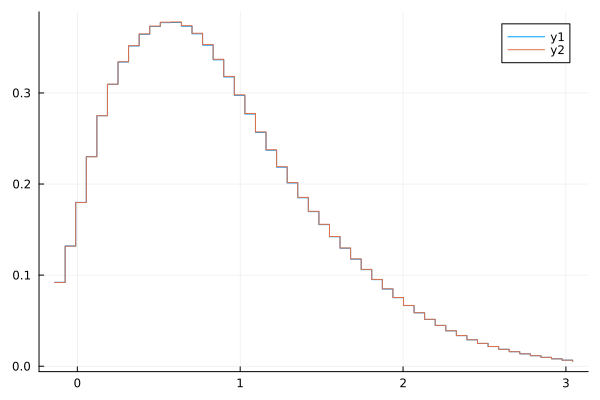

In [113]:
plot(
    range(log10(emin), log10(emax), 50),
    [edistbinnedtrue edistbinnedalt],
    seriestype=:step
)

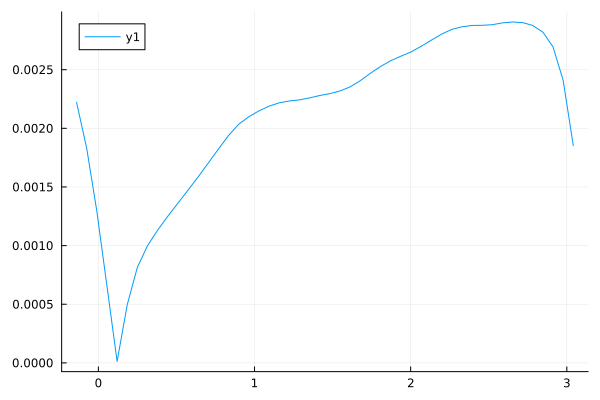

In [114]:
plot(
    range(log10(emin), log10(emax), 50),
    abs.((edistbinnedtrue .- edistbinnedalt) ./ edistbinnedtrue)
)

In [216]:
# All sky binning and sensitivity functions

# Unsmeared by angle, but if we're taking the whole sky events we don't care about angular resolution
function allskyevents(dm2, σ, ϕ₀, γ, nb)
    bsize = π/nb

    b_range = (-π/2+bsize):bsize:(π/2-bsize)
    l_range = (0+bsize/2):bsize:(2π-bsize/2)

    # Going to be a vector of vectors
    skybins = [zeros(50) for _ in 1:length(b_range), _ in 1:length(l_range)]

    for (j, l) in enumerate(l_range)
        for (i, b) in enumerate(b_range)
            if i > nb/4 && i < 3*nb/4
                skybins[i, j] = edistbinnedfreeparams(dm2, l, (-b), σ, bsize, ϕ₀, γ)
            end
        end
    end

    return sum(skybins)
end

# This function takes as inputs the mass splitting value, the free flux parameters, the energy
# resolution (0.5 ish for IceCube cascade events), the angular resolution,
# (7 degrees ish for IceCube cascade events), and the variable 'nb', which determines how finely the events are sampled.
# nb = 80 seems to be a good mix of speed and accuracy for total event count.
function anglesmear(dm2, ϕ₀, γ, σ, res, nb)

    bsize = π/nb

    # Healpix angle labeling scheme
    θedges = (bsize):bsize:(π-bsize)
    ϕedges = (0+bsize/2):bsize:(2π-bsize/2)

    # Convert to galactic coordinate angle scheme
    b_range = -(θedges .- π/2)
    l_range = ϕedges

    # Initializing a matrix of 50-vectors to hold the event distributions at each sky bin
    skybins = [zeros(50) for _ in 1:length(b_range), _ in 1:length(l_range)]

    # Setting all the event numbers outside of -pi/4 to pi/4 to 0 because they're so small anyway it doesn't really
    # change anything––speeds things up a ton
    for (j, l) in enumerate(l_range)
        for (i, b) in enumerate(b_range)
            if i > nb/4 && i < 3*nb/4
                skybins[i, j] = edistbinnedfreeparams(dm2, l, b, σ, bsize, ϕ₀, γ)
            end
        end
    end

    edistvals1 = transpose(skybins)

    # Splitting the data into all-sky maps for each energy bin
    matrix = zeros(length(l_range), length(b_range))
    ebins = [copy(matrix) for _ in 1:50]
    for i in 1:50
        for j in 1:length(l_range)
            for k in 1:length(b_range)
                ebins[i][j, k] = edistvals1[j, k][i]
            end
        end
    end

    # Converting from angles to the appropriate pixels in the Healpix scheme
    nside = 128
    npix = hp.nside2npix(nside)
    theta, phi = np.meshgrid(θedges, ϕedges)
    pixel_indices = hp.ang2pix(nside, vec(theta), vec(phi)) .+ 1 # the addition is for changing indexing to Julia indexing

    # Function that converts a smoothed healpix map to a 2d array/matrix 
    function conv(map)
        mat_smoothed = zeros(npix, 3)

        for i in 1:npix
            θ, ϕ = Healpix.pix2ang(map, i) # The Julia Healpix.jl package does this a lot faster than healpy
            mat_smoothed[i, 1] = θ - π/2
            if ϕ < π
                mat_smoothed[i, 2] = ϕ
            else
                mat_smoothed[i, 2] = ϕ - 2π
            end
            mat_smoothed[i, 3] = map[i]
        end
        return mat_smoothed
    end

    # Function that does the actual angular smearing with healpy
    function smoothing(emap, i, res)

        bin = emap[i]
        e = []

        for (j, thval) in enumerate(θedges)
            for (i, phval) in enumerate(ϕedges)
                    push!(e, bin[i, j])
            end
        end

        E = np.zeros(hp.nside2npix(nside))

        E[pixel_indices] = e

        E_smoothing = hp.smoothing(E, fwhm=np.radians(res))

        # Initializing a Julia healpix map so we can use conv
        hpmap = Healpix.HealpixMap{Float64, Healpix.RingOrder}(E_smoothing)

        mat_smoothed = conv(hpmap)

        # Rebinning to match the initial sampling resolution
        bbins = (-π/2):bsize:(π/2)
        lbins = (-π):bsize:(π)
        binned = fit(Histogram, (mat_smoothed[:, 1], mat_smoothed[:, 2]), weights(mat_smoothed[:, 3]), (bbins, lbins), closed=:right)

        return binned.weights
    end

    # We return a vector with smeared skymaps for each energy bin
    smearedebins = [smoothing(ebins, i, res) for i in 1:50]

    bbins = size(smearedebins[1])[1]
    lbins = size(smearedebins[1])[2]

    allskyedists = [zeros(50) for _ in 1:bbins, _ in 1:lbins]

    for i in 1:bbins
        for j in 1:lbins
            allskyedists[i, j] = [smearedebins[k][i, j] for k in 1:50]
        end
    end

    return allskyedists

end

# Bins the final array into square lat/long bins
function anglesmearbin(dm2, ϕ₀, γ, σ, res, nb)

    bsize = π/nb

    # Healpix angle labeling scheme
    θedges = (bsize):bsize:(π-bsize)
    ϕedges = (0+bsize/2):bsize:(2π-bsize/2)

    # Convert to galactic coordinate angle scheme
    b_range = -(θedges .- π/2)
    l_range = ϕedges

    # Initializing a matrix of 50-vectors to hold the event distributions at each sky bin
    skybins = [zeros(50) for _ in 1:length(b_range), _ in 1:length(l_range)]

    # Setting all the event numbers outside of -pi/4 to pi/4 to 0 because they're so small anyway it doesn't really
    # change anything––speeds things up a ton
    for (j, l) in enumerate(l_range)
        for (i, b) in enumerate(b_range)
            if i > nb/4 && i < 3*nb/4
                skybins[i, j] = edistbinnedfreeparams(dm2, l, b, σ, bsize, ϕ₀, γ)
            end
        end
    end

    edistvals1 = transpose(skybins)

    # Splitting the data into all-sky maps for each energy bin
    matrix = zeros(length(l_range), length(b_range))
    ebins = [copy(matrix) for _ in 1:50]
    for i in 1:50
        for j in 1:length(l_range)
            for k in 1:length(b_range)
                ebins[i][j, k] = edistvals1[j, k][i]
            end
        end
    end

    # Converting from angles to the appropriate pixels in the Healpix scheme
    nside = 128
    npix = hp.nside2npix(nside)
    theta, phi = np.meshgrid(θedges, ϕedges)
    pixel_indices = hp.ang2pix(nside, vec(theta), vec(phi)) .+ 1 # the addition is for changing indexing to Julia indexing

    # Function that converts a smoothed healpix map to a 2d array/matrix 
    function conv(map)
        mat_smoothed = zeros(npix, 3)

        for i in 1:npix
            θ, ϕ = Healpix.pix2ang(map, i) # The Julia Healpix.jl package does this a lot faster than healpy
            mat_smoothed[i, 1] = θ - π/2
            if ϕ < π
                mat_smoothed[i, 2] = ϕ
            else
                mat_smoothed[i, 2] = ϕ - 2π
            end
            mat_smoothed[i, 3] = map[i]
        end
        return mat_smoothed
    end

    # Function that does the actual angular smearing with healpy
    function smoothing(emap, i, res)

        bin = emap[i]
        e = []

        for (j, thval) in enumerate(θedges)
            for (i, phval) in enumerate(ϕedges)
                    push!(e, bin[i, j])
            end
        end

        E = np.zeros(hp.nside2npix(nside))

        E[pixel_indices] = e

        E_smoothing = hp.smoothing(E, fwhm=np.radians(res))

        # Initializing a Julia healpix map so we can use conv
        hpmap = Healpix.HealpixMap{Float64, Healpix.RingOrder}(E_smoothing)

        mat_smoothed = conv(hpmap)

        # Rebinning to match the DESIRED angular resolution
        bsize = π/(180/res)
        bbins = (-π/2):bsize:(π/2)
        lbins = (-π):bsize:(π)
        binned = fit(Histogram, (mat_smoothed[:, 1], mat_smoothed[:, 2]), weights(mat_smoothed[:, 3]), (bbins, lbins), closed=:right)

        return binned.weights
    end

    # We return a vector with smeared skymaps for each energy bin
    smearedebins = [smoothing(ebins, i, res) for i in 1:50]

    bbins = size(smearedebins[1])[1]
    lbins = size(smearedebins[1])[2]

    allskyedists = [zeros(50) for _ in 1:bbins, _ in 1:lbins]

    for i in 1:bbins
        for j in 1:lbins
            allskyedists[i, j] = [smearedebins[k][i, j] for k in 1:50]
        end
    end

    return allskyedists

end

# angres in radians
function convΩ(array, angres)
    Ω = 2π * (1 - cos(angres/2))    
    array_Ω = array ./ Ω
end

function negloglh2(dm2, l, b, σ, res, ϕ₀, γ)

    nullhyp = edistbinnedfreeparams(0, l, b, σ, res, 21.8, 2.7) * 0.94
    althyp = edistbinnedfreeparams(dm2, l, b, σ, res, ϕ₀, γ) * 0.94

    altsummand = poissonlog.(nullhyp, althyp)

    nloglh = -sum(altsummand)
end

# Approximate negloglh all sky function
function allskynllh(dm2, ϕ₀, γ, σ, res)

    res_rad = res * (π/180)

    sumllh = 0

    # This sampling gets the majority of events and gives an *almost* maximized parameter set
    for lval in (-pi/2):res_rad:(pi/2)
        for bval in (-0.122):res_rad:(0.122)
            sumllh += negloglh2(dm2, lval, bval, σ, res_rad, ϕ₀, γ)
        end
    end
    
    return sumllh
end

function allskymaxlh(dm2, σ, res)

    function nllh(test)
        return allskynllh(dm2, test[1], test[2], σ, res)
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, NelderMead())
end

# all-sky LRT function as a function of delta m^2 and the angular resolution we want
function lhratio(dm2, σ, res)

    # We first find the maximum-likelihood parameters:
    opt = allskymaxlh(dm2, σ, res)
    optparams = Optim.minimizer(opt)

    nullarray = anglesmearbin(0, 21.8, 2.7, σ, res, 80)
    testarray = anglesmearbin(dm2, optparams[1], optparams[2], σ, res, 80)

    bbins, lbins = size(nullarray)
    
    array = zeros(bbins, lbins)
    for i in 1:bbins
        for j in 1:lbins
            array[i, j] = lrt(nullarray[i, j], testarray[i, j])
            # Zero'ing out any values that don't make sense in our grid
            if isnan(array[i, j])
                array[i, j] = 0
            end
        end
    end

    return array
end

# All sky sensitivity function
function allskyts(dm2, σ)

    mxlhallsky = allskymaxlh(dm2, σ, 7)
    allskymaxparams = Optim.minimizer(mxlhallsky)

    # Again, don't need to worry about angular smearing here, can just take the whole sky as a bin
    askyevents_null = allskyevents(0, 21.8, 2.7, 80)
    askyeventsalt_maxlh = allskyevents(dm2, allskymaxparams[1], allskymaxparams[2], 80)


    ts = lrt(askyevents_null, askyeventsalt_maxlh)
end

# Real all sky sensitivity function!

function allskyts_real(dm2, σ, θres)

    mxlhallsky = allskymaxlh(dm2, σ, 1.8)
    allskymaxparams = Optim.minimizer(mxlhallsky)

    askyevents_null = anglesmear(0, 21.8, 2.7, σ, θres, 100) * 0.94
    askyevents_alt_maxlh = anglesmear(dm2, allskymaxparams[1], allskymaxparams[2], σ, θres, 100) * 0.94

    bsize, lsize = size(askyevents_null)
    ts_vals = zeros(bsize, lsize)

    for j in 1:lsize
        for i in 1:bsize
            ts_vals[i, j] = lrt(askyevents_null[i, j], askyevents_alt_maxlh[i, j])
        end
    end
    
    return sum(ts_vals)
end

allskyts_real (generic function with 1 method)

In [214]:
# testallskyts3 = allskyts_real(10^(-14), 0.5, 3)

38.96614849673692

In [212]:
# testallskyts7 = allskyts_real(10^(-14), 0.5, 7)

34.35557016751396

In [213]:
# testallskyts12 = allskyts_real(10^(-14), 0.5, 12)

31.650899980614255

In [197]:
function negloglh2_test(dm2, l, b, σ, res, ϕ₀, γ)

    # 0.94 assuming that res = π/100
    nullhyp = edistbinnedfreeparams(0, l, b, σ, res, 21.8, 2.7) * 0.94
    althyp = edistbinnedfreeparams(dm2, l, b, σ, res, ϕ₀, γ) * 0.94

    altsummand = poissonlog.(nullhyp, althyp)

    nloglh = -sum(altsummand)
end

function allskynllh_test(dm2, ϕ₀, γ, σ)

    # res_rad = res * (π/180)

    sumllh = 0

    sdens = π/100

    # Let's always do actual sampling at π/100 density

    # Length of 100 at sdens = π/100
    lsample = (-π/2):sdens:(π/2)

    # Length of 8 at sdens = π/100
    # bsample = (-π/26):sdens:(π/26)
    bsample = (-0.122):sdens:(0.122)
    # events = zeros(length(lsample), length(bsample))
    events_null = [edistbinnedfreeparams(0, l, b, σ, sdens, 21.8, 2.7) * 0.94 for b in bsample, l in lsample]
    events_alt = [edistbinnedfreeparams(dm2, l, b, σ, sdens, ϕ₀, γ) * 0.94 for b in bsample, l in lsample]
    lhs = zeros(length(lsample), length(bsample))
    # for i in length(bsample)
    #     for j in length(lsample)
    #     lhs[i, j] = poissonlog(events_null[i, j], events_alt[i, j])
    #     end
    # end
    # return lhs
    lhs = [poissonlog.(events_null[i, j], events_alt[i, j]) for i in 1:length(bsample), j in 1:length(lsample)]
    return -sum(sum(lhs))

    # nloglh = -lhs

    # bconcatnum = round(res_rad/sdens)
    # final_bdim = round(length(bsample)/bconcatnum)
    # final_ldim = round(length(lsample)/bconcatnum)
    # bconcatnum_l = length(lsample)/final_ldim

    # for lval in lsample
    #     for bval in bsample
    #         sumllh += negloglh2_test(dm2, lval, bval, σ, res_rad, ϕ₀, γ)
    #     end
    # end
    
    # return sumllh
end

function allskymaxlh_test(dm2, σ)

    function nllh(test)
        return allskynllh_test(dm2, test[1], test[2], σ)
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, NelderMead())
end

allskymaxlh_test (generic function with 1 method)

In [175]:
# allskynllh_test(10^(-14), 21.8, 2.7, 0.5)

2175.2690348334518

In [202]:
# orig = allskymaxlh(10^(-14), 0.5, 1.8)
# newtest = allskymaxlh_test(10^(-14), 0.5)

 * Status: success

 * Candidate solution
    Final objective value:     2.203003e+03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   277  (vs limit Inf)
    Iterations:    40
    f(x) calls:    81


In [207]:
# orig_2 = allskymaxlh(10^(-14), 0.5, 7)

 * Status: success

 * Candidate solution
    Final objective value:     1.200013e+03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    39
    f(x) calls:    80


In [208]:
# Optim.minimizer(orig_2)

2-element Vector{Float64}:
 20.442498368548396
  2.9260368575395335

In [203]:
# Optim.minimizer(orig)

2-element Vector{Float64}:
 19.21442325165395
  2.937360813501675

In [204]:
# Optim.minimizer(newtest)

2-element Vector{Float64}:
 19.21442325165395
  2.937360813501675

In [200]:
# allskynllh_test(10^(-14), 21, 2.7, 0.5)

2311.80523130688

In [201]:
# allskynllh(10^(-14), 21, 2.7, 0.5, 1.8)

2311.805231306881

In [117]:
# If nb = 100, normalize by 0.94

function allskyevents_free_eres(dm2, ϕ₀, γ, σ, nb)
    bsize = π/nb

    b_range = (-π/2+bsize):bsize:(π/2-bsize)
    l_range = (0+bsize/2):bsize:(2π-bsize/2)

    # Going to be a vector of vectors
    skybins = [zeros(50) for _ in 1:length(b_range), _ in 1:length(l_range)]

    for (j, l) in enumerate(l_range)
        for (i, b) in enumerate(b_range)
            if i > 2nb/5 && i < 3nb/5
                skybins[i, j] = edistbinnedfreeparams(dm2, l, (-b), σ, bsize, ϕ₀, γ)
            end
        end
    end

    return sum(skybins)
end

allskyevents_free_eres (generic function with 1 method)